## DenseNet121 - BGR

## DenseNet121 - RGB

## DenseNet121 - RGB & Data Preprossed

#### 환경구성

In [ ]:
%pwd

'/Users/junghyun/Desktop/Python/DeepNoid'

In [ ]:
import os
import cv2
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [ ]:
# [MacOS] GPU 설정 및 사용 가능 체크
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    print("GPU is available")
else:
    print("GPU is not available, using CPU")

GPU is available


In [ ]:
# [MacOS] 그래픽카드 메모리 정리 메소드
import gc
class MemoryCleanupCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        gc.collect()
        tf.keras.backend.clear_session()
        print("GPU memory was cleaned!")

#### 데이터 로드

In [ ]:
def load_and_preprocess_data(base_dir, img_size=(128, 128)):
    images = []
    labels = []
    categories = ['BENIGN', 'MALIGNANT'] # 카테고리

    for category in categories:
        class_num = categories.index(category)  # benign: 0, malignant: 1
        base_path = os.path.join(base_dir, category)
        base_files = os.listdir(base_path)

        for idx in range(1000):
            image_path = os.path.join(base_path, base_files[idx])
            image_bgr = cv2.imread(image_path)
            
            # 노이즈 제거
            image_bgr = cv2.fastNlMeansDenoisingColored(image_bgr, None, 10, 10, 7, 21)
            
            # YUV 컬로 포맷으로 변환
            image_yuv = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2YUV)
            # 히스토그램 평활화 적용
            image_yuv[:, :, 0] = cv2.equalizeHist(image_yuv[:, :, 0])
            # #RGB로 변환
            image_rgb = cv2.cvtColor(image_yuv, cv2.COLOR_YUV2RGB)
            
            image_rgb = cv2.resize(image_rgb, img_size)
            images.append(image_rgb)
            labels.append(class_num)

    # 정규화
    images = np.array(images).astype('float32') / 255.0
    return images, np.array(labels)

In [ ]:
base_dir = 'datasets/skin-cancer' # 데이터 경로
X, y = load_and_preprocess_data(base_dir) # 2000장 데이터 로드

(-0.5, 127.5, 127.5, -0.5)

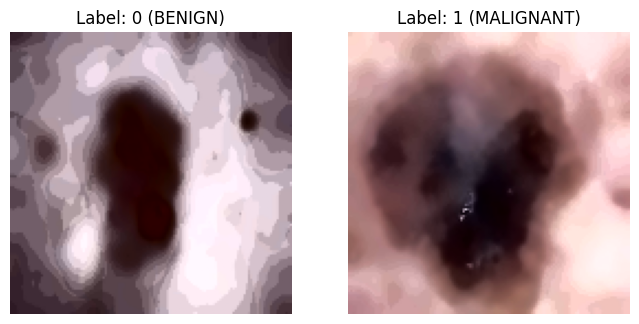

In [ ]:
# 라벨이 0인 이미지와 1인 이미지 각각 하나씩 가져오기
sample_image_0 = X[y == 0][1].reshape(128, 128, 3)
sample_image_1 = X[y == 1][1].reshape(128, 128, 3)

# 샘플 이미지 시각화
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

axes[0].imshow(sample_image_0)
axes[0].set_title("Label: 0 (BENIGN)")
axes[0].axis('off')

axes[1].imshow(sample_image_1)
axes[1].set_title("Label: 1 (MALIGNANT)")
axes[1].axis('off')

#### 데이터 분할

In [ ]:
def split_data(X, y, test_size=0.2, val_size=0.5):
    X_train, X_val_test, y_train, y_val_test = train_test_split(X,  # image data
                                                                y,  # label data
                                                                test_size=test_size, # X_train, y_train에 80%의 데이터 입력
                                                                stratify=y,  # normal, pneumonia 클래스의 비율을 맞춰서 분할하기 위함
                                                                random_state=42)  # 랜덤시드 설정
    X_val, X_test, y_val, y_test = train_test_split(X_val_test,
                                                    y_val_test,
                                                    test_size=val_size,  # 남은 20% 데이터를 1/2로 나눔 -> val:test = 1:1 (10% : 10%)
                                                    stratify=y_val_test,
                                                    random_state=42)
    return X_train, y_train, X_val, y_val, X_test, y_test

In [ ]:
X_train, y_train, X_val, y_val, X_test, y_test = split_data(X, y) # train, val, test data split

In [ ]:
print("데이터 로딩 및 전처리 완료")
print(f"훈련 데이터 형태: {X_train.shape}, 레이블 형태: {y_train.shape}")
print(f"검증 데이터 형태: {X_val.shape}, 레이블 형태: {y_val.shape}")
print(f"테스트 데이터 형태: {X_test.shape}, 레이블 형태: {y_test.shape}")

데이터 로딩 및 전처리 완료
훈련 데이터 형태: (1600, 128, 128, 3), 레이블 형태: (1600,)
검증 데이터 형태: (200, 128, 128, 3), 레이블 형태: (200,)
테스트 데이터 형태: (200, 128, 128, 3), 레이블 형태: (200,)


#### 모델 생성

In [ ]:
def create_densenet121_model(input_shape):
    # DenseNet121 모델을 생성, 사전학습된 ImageNet 가중치를 사용, include_top=False로 설정하여 최상위 층을 제거
    base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False  # 사전학습된 가중치는 고정

    # 완전 연결 계층 추가
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    output = Dense(1, activation='sigmoid')(x)

    # 입력과 출력을 지정하여 모델 생성
    model = Model(inputs=base_model.input, outputs=output)

    return model

In [ ]:
# 모델 생성
model = create_densenet121_model(input_shape=(128, 128, 3))

# 모델 컴파일
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='binary_crossentropy',  # 다중 클래스 분류를 위한 손실 함수
              metrics=['accuracy'])

# 콜백 설정
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
    tf.keras.callbacks.ModelCheckpoint('best_densenet_model.h5', save_best_only=True)
]

Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



2024-07-10 16:15:14.560135: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-07-10 16:15:14.560931: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


#### 학습

In [ ]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    callbacks=callbacks
)

Epoch 1/50


2024-07-10 16:15:18.122657: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2024-07-10 16:15:20.841704: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


50/50 [==============================] - ETA: 0s - loss: 0.5440 - accuracy: 0.7312

2024-07-10 16:15:31.886561: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


50/50 [==============================] - 19s 230ms/step - loss: 0.5440 - accuracy: 0.7312 - val_loss: 0.4770 - val_accuracy: 0.7700
Epoch 2/50
50/50 [==============================] - 7s 130ms/step - loss: 0.3936 - accuracy: 0.8206 - val_loss: 0.4324 - val_accuracy: 0.8000
Epoch 3/50
50/50 [==============================] - 7s 138ms/step - loss: 0.3412 - accuracy: 0.8512 - val_loss: 0.4102 - val_accuracy: 0.8000
Epoch 4/50
50/50 [==============================] - 7s 131ms/step - loss: 0.3129 - accuracy: 0.8737 - val_loss: 0.4029 - val_accuracy: 0.8050
Epoch 5/50
50/50 [==============================] - 6s 126ms/step - loss: 0.2868 - accuracy: 0.8856 - val_loss: 0.4189 - val_accuracy: 0.8000
Epoch 6/50
50/50 [==============================] - 7s 147ms/step - loss: 0.2669 - accuracy: 0.8944 - val_loss: 0.4169 - val_accuracy: 0.8300
Epoch 7/50
50/50 [==============================] - 7s 132ms/step - loss: 0.2477 - accuracy: 0.9038 - val_loss: 0.3966 - val_accuracy: 0.8100
Epoch 8/50
50/50

In [ ]:
model = tf.keras.models.load_model('best_densenet_model.h5')

In [ ]:
test_loss, test_acc = model.evaluate(X_test, y_test) # 테스트 데이터로 평가
print(f"Test Accuracy: {test_acc:.4f}")

2024-07-10 16:17:22.580409: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


7/7 [==============================] - 5s 280ms/step - loss: 0.3547 - accuracy: 0.8300
Test Accuracy: 0.8300


In [ ]:
y_pred = model.predict(X_test) # 테스트 데이터로 예측
y_pred_classes = (y_pred > 0.5).astype(int).flatten() # 예측값을 0과 1로 변환

2024-07-10 16:17:27.252927: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


7/7 [==============================] - 5s 376ms/step


#### 결과 확인

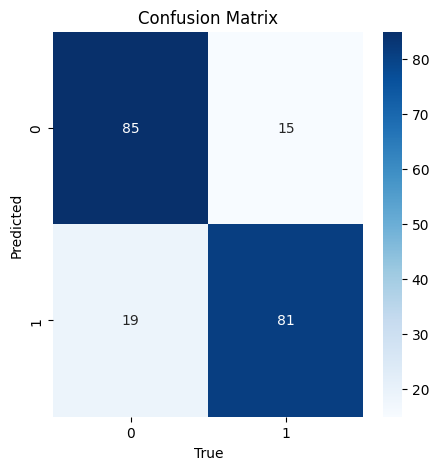

In [ ]:
cm = confusion_matrix(y_test, y_pred_classes) # 오차행렬

plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('True')
plt.ylabel('Predicted')
plt.show()

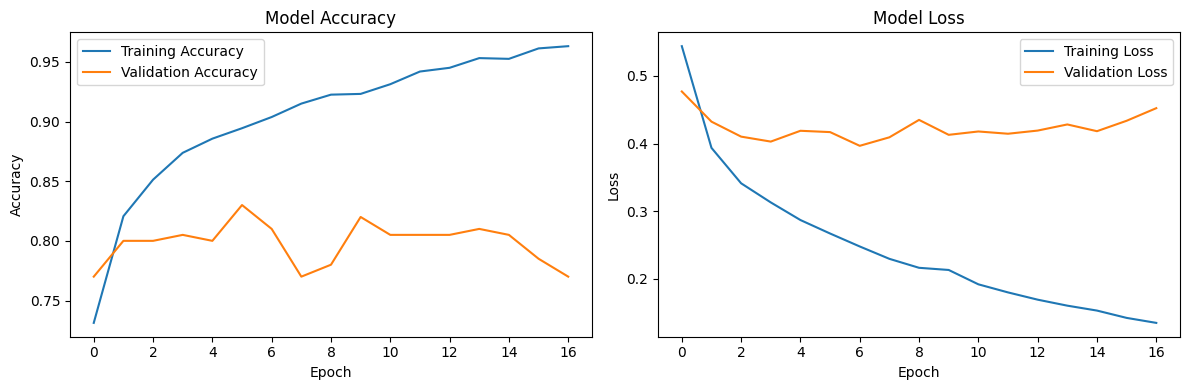

In [ ]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

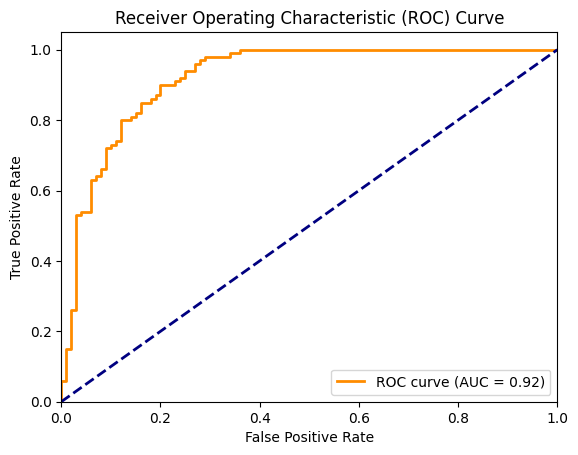

In [ ]:
from sklearn.metrics import roc_curve, auc

# ROC 곡선 계산
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

# ROC 곡선 그리기
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

### 환경구성

In [ ]:
%pwd

'/Users/junghyun/Desktop/Python/DeepNoid/RGB'

In [ ]:
import os
import cv2
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [ ]:
# [MacOS] GPU 설정 및 사용 가능 체크
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    print("GPU is available")
else:
    print("GPU is not available, using CPU")

GPU is available


In [ ]:
# [MacOS] 그래픽카드 메모리 정리 메소드
import gc
class MemoryCleanupCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        gc.collect()
        tf.keras.backend.clear_session()
        print("GPU memory was cleaned!")

#### 데이터 로드

In [ ]:
def load_and_preprocess_data(base_dir, img_size=(128, 128)):
    images = []
    labels = []
    categories = ['BENIGN', 'MALIGNANT'] # 카테고리

    for category in categories:
        class_num = categories.index(category)  # benign: 0, malignant: 1
        base_path = os.path.join(base_dir, category)
        base_files = os.listdir(base_path)

        for idx in range(1000):
            image_path = os.path.join(base_path, base_files[idx])
            
            image = cv2.imread(image_path)  # color로 이미지 데이터 받아오기
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # BGR에서 RGB로 변환
            image = cv2.resize(image, img_size)  # 이미지 사이즈 resize
            
            images.append(image)
            labels.append(class_num)

    # 정규화
    images = np.array(images).astype('float32') / 255.0
    return images, np.array(labels)

In [ ]:
base_dir = '../datasets/skin-cancer' # 데이터 경로
X, y = load_and_preprocess_data(base_dir) # 2000장 데이터 로드

(-0.5, 127.5, 127.5, -0.5)

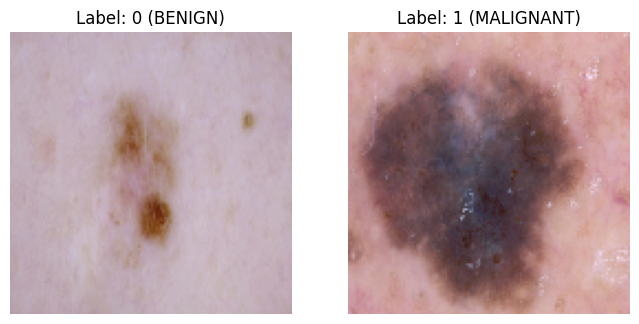

In [ ]:
# 라벨이 0인 이미지와 1인 이미지 각각 하나씩 가져오기
sample_image_0 = X[y == 0][1].reshape(128, 128, 3)
sample_image_1 = X[y == 1][1].reshape(128, 128, 3)

# 샘플 이미지 시각화
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

axes[0].imshow(sample_image_0)
axes[0].set_title("Label: 0 (BENIGN)")
axes[0].axis('off')

axes[1].imshow(sample_image_1)
axes[1].set_title("Label: 1 (MALIGNANT)")
axes[1].axis('off')

#### 데이터 분할

In [ ]:
def split_data(X, y, test_size=0.2, val_size=0.5):
    X_train, X_val_test, y_train, y_val_test = train_test_split(X,  # image data
                                                                y,  # label data
                                                                test_size=test_size, # X_train, y_train에 80%의 데이터 입력
                                                                stratify=y,  # normal, pneumonia 클래스의 비율을 맞춰서 분할하기 위함
                                                                random_state=42)  # 랜덤시드 설정
    X_val, X_test, y_val, y_test = train_test_split(X_val_test,
                                                    y_val_test,
                                                    test_size=val_size,  # 남은 20% 데이터를 1/2로 나눔 -> val:test = 1:1 (10% : 10%)
                                                    stratify=y_val_test,
                                                    random_state=42)
    return X_train, y_train, X_val, y_val, X_test, y_test

In [ ]:
X_train, y_train, X_val, y_val, X_test, y_test = split_data(X, y) # train, val, test data split

In [ ]:
print("데이터 로딩 및 전처리 완료")
print(f"훈련 데이터 형태: {X_train.shape}, 레이블 형태: {y_train.shape}")
print(f"검증 데이터 형태: {X_val.shape}, 레이블 형태: {y_val.shape}")
print(f"테스트 데이터 형태: {X_test.shape}, 레이블 형태: {y_test.shape}")

데이터 로딩 및 전처리 완료
훈련 데이터 형태: (1600, 128, 128, 3), 레이블 형태: (1600,)
검증 데이터 형태: (200, 128, 128, 3), 레이블 형태: (200,)
테스트 데이터 형태: (200, 128, 128, 3), 레이블 형태: (200,)


#### 모델 생성

In [ ]:
def create_densenet121_model(input_shape):
    # DenseNet121 모델을 생성, 사전학습된 ImageNet 가중치를 사용, include_top=False로 설정하여 최상위 층을 제거
    base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False  # 사전학습된 가중치는 고정

    # 완전 연결 계층 추가
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    output = Dense(1, activation='sigmoid')(x)

    # 입력과 출력을 지정하여 모델 생성
    model = Model(inputs=base_model.input, outputs=output)

    return model

In [ ]:
# 모델 생성
model = create_densenet121_model(input_shape=(128, 128, 3))

# 모델 컴파일
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='binary_crossentropy',  # 다중 클래스 분류를 위한 손실 함수
              metrics=['accuracy'])

# 콜백 설정
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
    tf.keras.callbacks.ModelCheckpoint('best_densenet_model.h5', save_best_only=True)
]

Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



2024-07-10 22:51:05.267114: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-07-10 22:51:05.267397: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


#### 학습

In [ ]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    callbacks=callbacks
)

Epoch 1/50


2024-07-10 22:51:07.880323: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2024-07-10 22:51:10.966743: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


50/50 [==============================] - ETA: 0s - loss: 0.5364 - accuracy: 0.7563

2024-07-10 22:51:19.020924: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


50/50 [==============================] - 16s 222ms/step - loss: 0.5364 - accuracy: 0.7563 - val_loss: 0.4308 - val_accuracy: 0.7800
Epoch 2/50
50/50 [==============================] - 8s 162ms/step - loss: 0.3796 - accuracy: 0.8388 - val_loss: 0.3931 - val_accuracy: 0.8250
Epoch 3/50
50/50 [==============================] - 7s 145ms/step - loss: 0.3373 - accuracy: 0.8625 - val_loss: 0.3795 - val_accuracy: 0.8300
Epoch 4/50
50/50 [==============================] - 7s 139ms/step - loss: 0.3048 - accuracy: 0.8775 - val_loss: 0.3790 - val_accuracy: 0.8050
Epoch 5/50
50/50 [==============================] - 7s 135ms/step - loss: 0.2821 - accuracy: 0.8938 - val_loss: 0.3683 - val_accuracy: 0.8250
Epoch 6/50
50/50 [==============================] - 6s 127ms/step - loss: 0.2630 - accuracy: 0.8975 - val_loss: 0.3777 - val_accuracy: 0.8300
Epoch 7/50
50/50 [==============================] - 7s 145ms/step - loss: 0.2534 - accuracy: 0.8994 - val_loss: 0.3654 - val_accuracy: 0.8400
Epoch 8/50
50/50

In [ ]:
model = tf.keras.models.load_model('best_densenet_model.h5')

In [ ]:
test_loss, test_acc = model.evaluate(X_test, y_test) # 테스트 데이터로 평가
print(f"Test Accuracy: {test_acc:.4f}")

2024-07-10 22:53:19.301737: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


7/7 [==============================] - 6s 405ms/step - loss: 0.3344 - accuracy: 0.8550
Test Accuracy: 0.8550


In [ ]:
y_pred = model.predict(X_test) # 테스트 데이터로 예측
y_pred_classes = (y_pred > 0.5).astype(int).flatten() # 예측값을 0과 1로 변환

2024-07-10 22:53:24.620870: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


7/7 [==============================] - 4s 310ms/step


#### 결과 확인

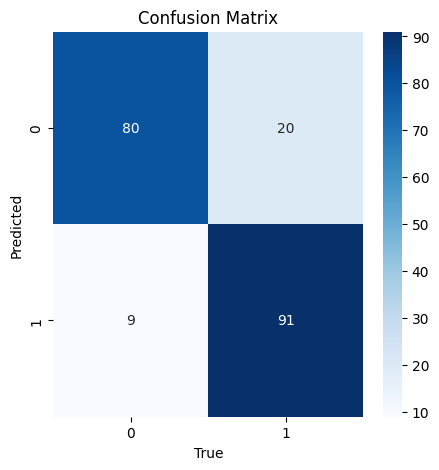

In [ ]:
cm = confusion_matrix(y_test, y_pred_classes) # 오차행렬

plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('True')
plt.ylabel('Predicted')
plt.show()

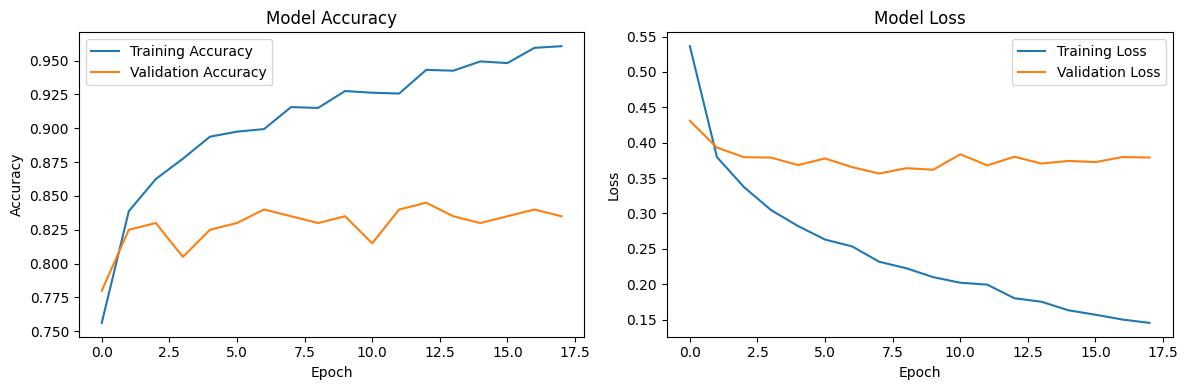

In [ ]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

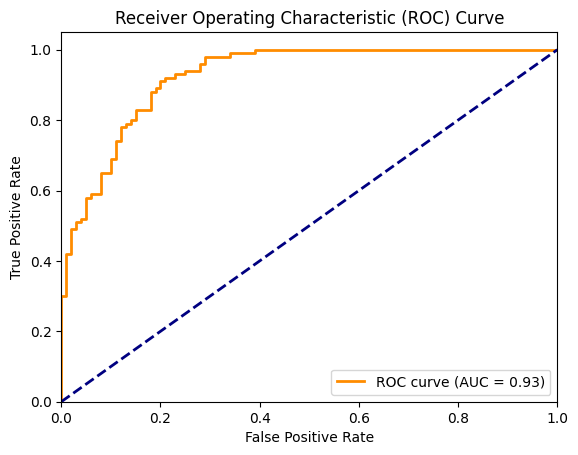

In [ ]:
from sklearn.metrics import roc_curve, auc

# ROC 곡선 계산
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

# ROC 곡선 그리기
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

#### 환경구성

In [7]:
%pwd

'/Users/junghyun/Desktop/Python/DeepNoid/BGR'

In [8]:
import os
import cv2
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [9]:
# [MacOS] GPU 설정 및 사용 가능 체크
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    print("GPU is available")
else:
    print("GPU is not available, using CPU")

GPU is available


In [10]:
# [MacOS] 그래픽카드 메모리 정리 메소드
import gc
class MemoryCleanupCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        gc.collect()
        tf.keras.backend.clear_session()
        print("GPU memory was cleaned!")

#### 데이터 로드

In [11]:
def load_and_preprocess_data(base_dir, img_size=(128, 128)):
    images = []
    labels = []
    categories = ['BENIGN', 'MALIGNANT'] # 카테고리

    for category in categories:
        class_num = categories.index(category)  # benign: 0, malignant: 1
        base_path = os.path.join(base_dir, category)
        base_files = os.listdir(base_path)

        for idx in range(1000):
            image_path = os.path.join(base_path, base_files[idx])
            image_rgb = cv2.imread(image_path)
            image_rgb = cv2.resize(image_rgb, img_size)
            images.append(image_rgb)
            labels.append(class_num)

    # 정규화
    images = np.array(images).astype('float32') / 255.0
    return images, np.array(labels)

In [12]:
base_dir = '../datasets/skin-cancer' # 데이터 경로
X, y = load_and_preprocess_data(base_dir) # 2000장 데이터 로드

(-0.5, 127.5, 127.5, -0.5)

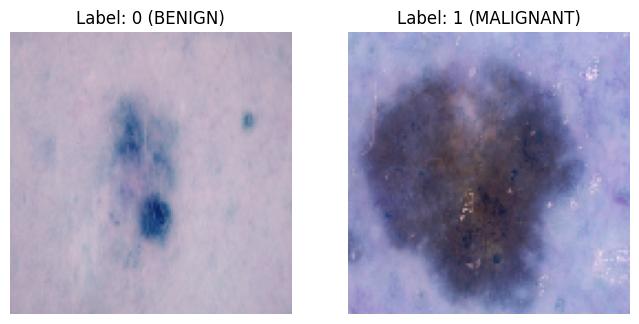

In [13]:
# 라벨이 0인 이미지와 1인 이미지 각각 하나씩 가져오기
sample_image_0 = X[y == 0][1].reshape(128, 128, 3)
sample_image_1 = X[y == 1][1].reshape(128, 128, 3)

# 샘플 이미지 시각화
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

axes[0].imshow(sample_image_0)
axes[0].set_title("Label: 0 (BENIGN)")
axes[0].axis('off')

axes[1].imshow(sample_image_1)
axes[1].set_title("Label: 1 (MALIGNANT)")
axes[1].axis('off')

#### 데이터 분할

In [14]:
def split_data(X, y, test_size=0.2, val_size=0.5):
    X_train, X_val_test, y_train, y_val_test = train_test_split(X,  # image data
                                                                y,  # label data
                                                                test_size=test_size, # X_train, y_train에 80%의 데이터 입력
                                                                stratify=y,  # normal, pneumonia 클래스의 비율을 맞춰서 분할하기 위함
                                                                random_state=42)  # 랜덤시드 설정
    X_val, X_test, y_val, y_test = train_test_split(X_val_test,
                                                    y_val_test,
                                                    test_size=val_size,  # 남은 20% 데이터를 1/2로 나눔 -> val:test = 1:1 (10% : 10%)
                                                    stratify=y_val_test,
                                                    random_state=42)
    return X_train, y_train, X_val, y_val, X_test, y_test

In [15]:
X_train, y_train, X_val, y_val, X_test, y_test = split_data(X, y) # train, val, test data split

In [16]:
print("데이터 로딩 및 전처리 완료")
print(f"훈련 데이터 형태: {X_train.shape}, 레이블 형태: {y_train.shape}")
print(f"검증 데이터 형태: {X_val.shape}, 레이블 형태: {y_val.shape}")
print(f"테스트 데이터 형태: {X_test.shape}, 레이블 형태: {y_test.shape}")

데이터 로딩 및 전처리 완료
훈련 데이터 형태: (1600, 128, 128, 3), 레이블 형태: (1600,)
검증 데이터 형태: (200, 128, 128, 3), 레이블 형태: (200,)
테스트 데이터 형태: (200, 128, 128, 3), 레이블 형태: (200,)


#### 모델 생성

In [17]:
def create_densenet121_model(input_shape):
    # DenseNet121 모델을 생성, 사전학습된 ImageNet 가중치를 사용, include_top=False로 설정하여 최상위 층을 제거
    base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False  # 사전학습된 가중치는 고정

    # 완전 연결 계층 추가
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    output = Dense(1, activation='sigmoid')(x)

    # 입력과 출력을 지정하여 모델 생성
    model = Model(inputs=base_model.input, outputs=output)

    return model

In [18]:
# 모델 생성
model = create_densenet121_model(input_shape=(128, 128, 3))

# 모델 컴파일
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='binary_crossentropy',  # 다중 클래스 분류를 위한 손실 함수
              metrics=['accuracy'])

# 콜백 설정
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
    tf.keras.callbacks.ModelCheckpoint('best_densenet_model.h5', save_best_only=True)
]

Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



2024-07-10 20:20:39.046385: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-07-10 20:20:39.047202: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


#### 학습

In [19]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    callbacks=callbacks
)

Epoch 1/50


2024-07-10 20:20:42.585981: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2024-07-10 20:20:45.210236: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


50/50 [==============================] - ETA: 0s - loss: 0.5156 - accuracy: 0.7725

2024-07-10 20:20:56.885400: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


50/50 [==============================] - 20s 251ms/step - loss: 0.5156 - accuracy: 0.7725 - val_loss: 0.4306 - val_accuracy: 0.8000
Epoch 2/50
50/50 [==============================] - 9s 171ms/step - loss: 0.3914 - accuracy: 0.8381 - val_loss: 0.3973 - val_accuracy: 0.8050
Epoch 3/50
50/50 [==============================] - 7s 142ms/step - loss: 0.3459 - accuracy: 0.8637 - val_loss: 0.3888 - val_accuracy: 0.8450
Epoch 4/50
50/50 [==============================] - 10s 195ms/step - loss: 0.3127 - accuracy: 0.8712 - val_loss: 0.3712 - val_accuracy: 0.8200
Epoch 5/50
50/50 [==============================] - 7s 141ms/step - loss: 0.2895 - accuracy: 0.8838 - val_loss: 0.3706 - val_accuracy: 0.8200
Epoch 6/50
50/50 [==============================] - 8s 153ms/step - loss: 0.2775 - accuracy: 0.8863 - val_loss: 0.3719 - val_accuracy: 0.8150
Epoch 7/50
50/50 [==============================] - 7s 141ms/step - loss: 0.2586 - accuracy: 0.9000 - val_loss: 0.3654 - val_accuracy: 0.8450
Epoch 8/50
50/5

In [20]:
model = tf.keras.models.load_model('best_densenet_model.h5')

In [21]:
test_loss, test_acc = model.evaluate(X_test, y_test) # 테스트 데이터로 평가
print(f"Test Accuracy: {test_acc:.4f}")

2024-07-10 20:23:06.339738: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


7/7 [==============================] - 5s 434ms/step - loss: 0.3672 - accuracy: 0.8350
Test Accuracy: 0.8350


In [22]:
y_pred = model.predict(X_test) # 테스트 데이터로 예측
y_pred_classes = (y_pred > 0.5).astype(int).flatten() # 예측값을 0과 1로 변환

2024-07-10 20:23:11.386226: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


7/7 [==============================] - 7s 608ms/step


#### 결과 확인

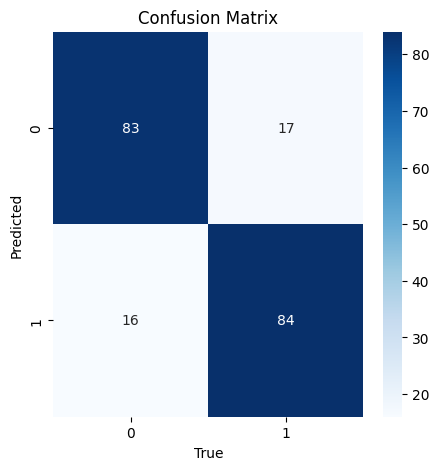

In [23]:
cm = confusion_matrix(y_test, y_pred_classes) # 오차행렬

plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('True')
plt.ylabel('Predicted')
plt.show()

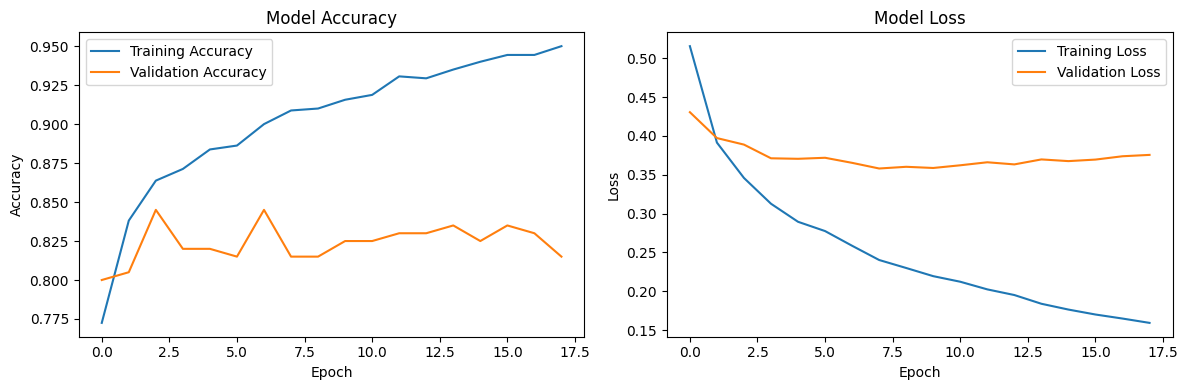

In [24]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

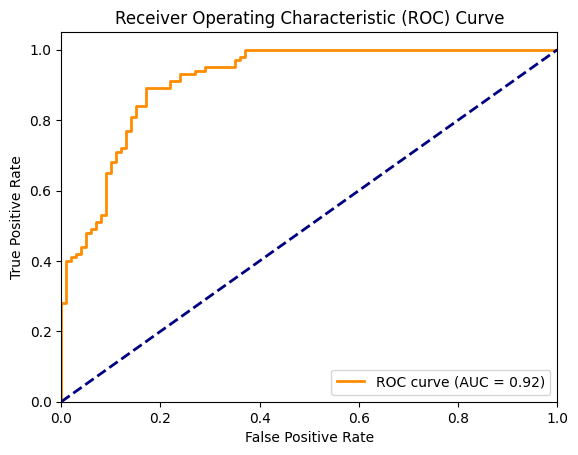

In [25]:
from sklearn.metrics import roc_curve, auc

# ROC 곡선 계산
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

# ROC 곡선 그리기
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()